# resnet 18

import and add name

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.models as models
import os
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm
from net import *
from PIL import Image


import torch.nn.functional as F
import torch.nn as nn
#from util import get_transform
#from util import get_acc
import util 


In [34]:
util.get_acc

AttributeError: module 'util' has no attribute 'get_acc'

hyperparameters

In [3]:
writer = SummaryWriter ('tf_logs_exp') 
batch_Size = 32
learning_rate = 3e-4
weight_decay = 1e-3
num_epoch = 1


 Define the model used

In [4]:
#model = get_resnext() 
#model = get_resnet()
model = get_resnet18()

Define the name of the training weights of the saved model

In [5]:
#model_path = r'model_save/resnet.pth' 
# model_path = r'model_save/resnext.pth'
model_path = r'model_save/resnet18.pth'

In [6]:
get_resnet18

<function net.get_resnet18()>

Use gpu if not can use cpu

In [7]:
def get_device():
    return 'cuda' if torch.cuda.is_available () else 'cpu'

Check if gpu is used correctly

In [8]:
device = get_device ()
print (device)

cuda


Import the correct address for train and valid

In [9]:
model = model.to (device)
train_path = r'dataset/train'
val_path = r'dataset/valid'

Do a transform on the data

In [10]:
# transforms_train = transforms.Compose (
#     [
#         transforms.Resize ([224, 224]),
#         transforms.ToTensor ()
#     ])

# transforms_vaild = transforms.Compose (
#     [
#         transforms.Resize ([224, 224]),
#         transforms.ToTensor ()
#     ])

train_dataset = torchvision.datasets.ImageFolder (root=train_path, transform=get_transform())
val_dataset = torchvision.datasets.ImageFolder (root=val_path, transform=get_transform())

print ('The dataset corresponding labels are:{}'.format (train_dataset.class_to_idx))

The dataset corresponding labels are:{'Albedo': 0, 'CC': 1, 'CuChulainn': 2, 'Gilgamesh': 3, 'Sesshomaru': 4}


In [11]:
train_loader = DataLoader (dataset=train_dataset, batch_size=batch_Size, shuffle=True)
val_loader = DataLoader (dataset=val_dataset, batch_size=batch_Size, shuffle=True)
print(train_loader,val_loader)

<torch.utils.data.dataloader.DataLoader object at 0x00000225181FF280> <torch.utils.data.dataloader.DataLoader object at 0x00000225181FFC70>


In [12]:
len(val_loader)*32

384

In [13]:
batch_images, batch_labels=next(iter(train_loader))

In [14]:
print(f"Image shape: {batch_images.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {batch_labels.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [15]:
class_name=train_dataset.classes

In [16]:
class_name

['Albedo', 'CC', 'CuChulainn', 'Gilgamesh', 'Sesshomaru']

In [19]:

my_image.permute(1, 2, 0)




NameError: name 'my_image' is not defined

C:\Users\21083\AppData\Local\Temp\ipykernel_21652\2439748209.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_img=torch.tensor(data=batch_images[i].permute(1, 2, 0))


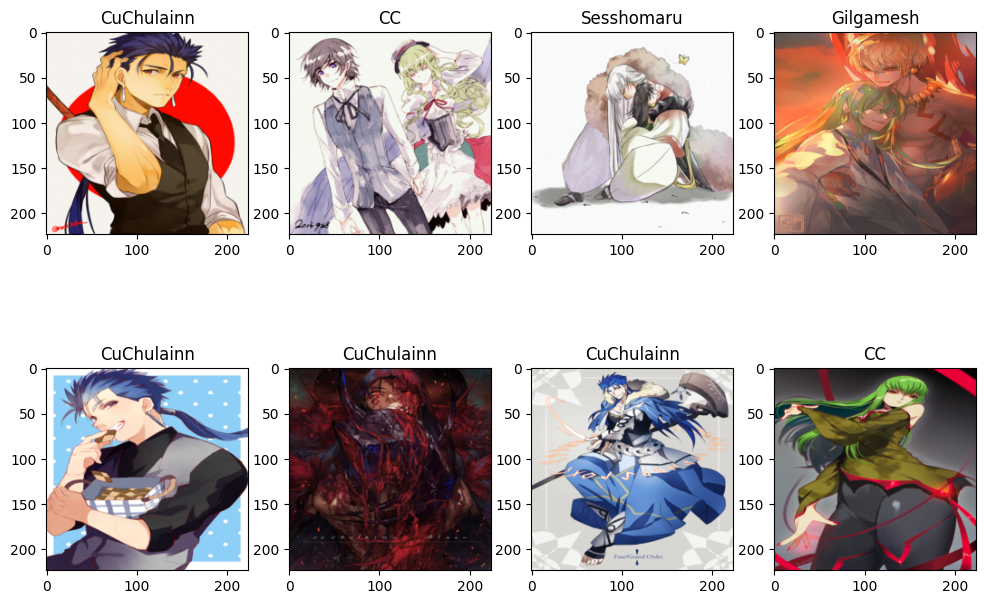

In [21]:
plt.figure(figsize=(12,8))

for i in range(8):
    plot_img=torch.tensor(data=batch_images[i].permute(1, 2, 0))
    plt.subplot(2,4,i+1)
    plt.title(class_name[batch_labels[i]])
    plt.imshow(plot_img)     

In [18]:
# 定义交叉熵损失函数，adam优化器，cos余弦学习率调整
criterion = nn.CrossEntropyLoss ()
optimizer = torch.optim.Adam (model.parameters (), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR (optimizer, T_max=10, eta_min=0, last_epoch=-1)

n_epochs = num_epoch

best_acc = 0.0

train_acc_list = []
train_loss_list = []

valid_loss_list = []
valid_acc_list = []


In [15]:
# 开始周期训练
for epoch in range (n_epochs):
    # ---------- Training ----------

    model.train ()
    train_loss = []
    train_accs = []

    i = 0

    for batch in tqdm (train_loader):

        imgs, labels = batch
        imgs = imgs.to (device)
        labels = labels.to (device)
        logits = model (imgs)
        # 计算loss
        loss = criterion (logits, labels)

        # 网络更新
        optimizer.zero_grad ()
        loss.backward ()
        optimizer.step ()
        scheduler.step ()

        #if (i % 500 == 0):
            #print ("learning_rate:", scheduler.get_last_lr ()[0])
       # i = i + 1

        acc = (logits.argmax (dim=-1) == labels).float ().mean ()

        train_loss.append (loss.item ())
        train_accs.append (acc.item ())

    train_loss = sum (train_loss) / len (train_loss)
    train_acc = sum (train_accs) / len (train_accs)

    print (f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    train_acc_list.append (train_acc)
    train_loss_list.append (train_loss)
    

    # 记录到tensorboard
    writer.add_scalar ('Train Loss ', train_acc, epoch)
    writer.add_scalar ('Train Accuracy ', train_loss, epoch)

    # ---------- Validation ----------
    model.eval ()

    valid_loss = []
    valid_accs = []

    for batch in tqdm (val_loader):
        imgs, labels = batch

        with torch.no_grad ():
            logits = model (imgs.to (device))

        loss = criterion (logits, labels.to (device))

        acc = (logits.argmax (dim=-1) == labels.to (device)).float ().mean ()

        valid_loss.append (loss.item ())
        valid_accs.append (acc)

    valid_loss = sum (valid_loss) / len (valid_loss)
    valid_acc = sum (valid_accs) / len (valid_accs)

    print (f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    valid_loss_list.append (valid_loss)
    valid_acc_list.append (valid_acc)

    # 保留在验证集上最好的模型
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save (model.state_dict (), model_path)
        print ('saving model with acc {:.3f}'.format (best_acc))

    writer.add_scalar ('Valid Loss ', valid_acc, epoch)
    writer.add_scalar ('Valid Accuracy ', valid_loss, epoch)


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [02:16<00:00,  2.40s/it]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "C:\Users\21083\.conda\envs\pytorch\lib\threading.py", line 950, in _bootstrap_inner


[ Train | 001/001 ] loss = 1.22553, acc = 0.53953


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]    self.run()
  File "C:\Users\21083\.conda\envs\pytorch\lib\site-packages\tensorboard\summary\writer\event_file_writer.py", line 233, in run
    self._record_writer.write(data)
  File "C:\Users\21083\.conda\envs\pytorch\lib\site-packages\tensorboard\summary\writer\record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "C:\Users\21083\.conda\envs\pytorch\lib\site-packages\tensorboard\compat\tensorflow_stub\io\gfile.py", line 766, in write
    self.fs.append(self.filename, file_content, self.binary_mode)
  File "C:\Users\21083\.conda\envs\pytorch\lib\site-packages\tensorboard\compat\tensorflow_stub\io\gfile.py", line 160, in append
    self._write(filename, file_content, "ab" if binary_mode else "a")
  File "C:\Users\21083\.conda\envs\pytorch\lib\site-packages\tensorboard\compat\tensorflow_stub\io\gfile.py", line 164

[ Valid | 001/001 ] loss = 1.28170, acc = 0.46632
saving model with acc 0.466


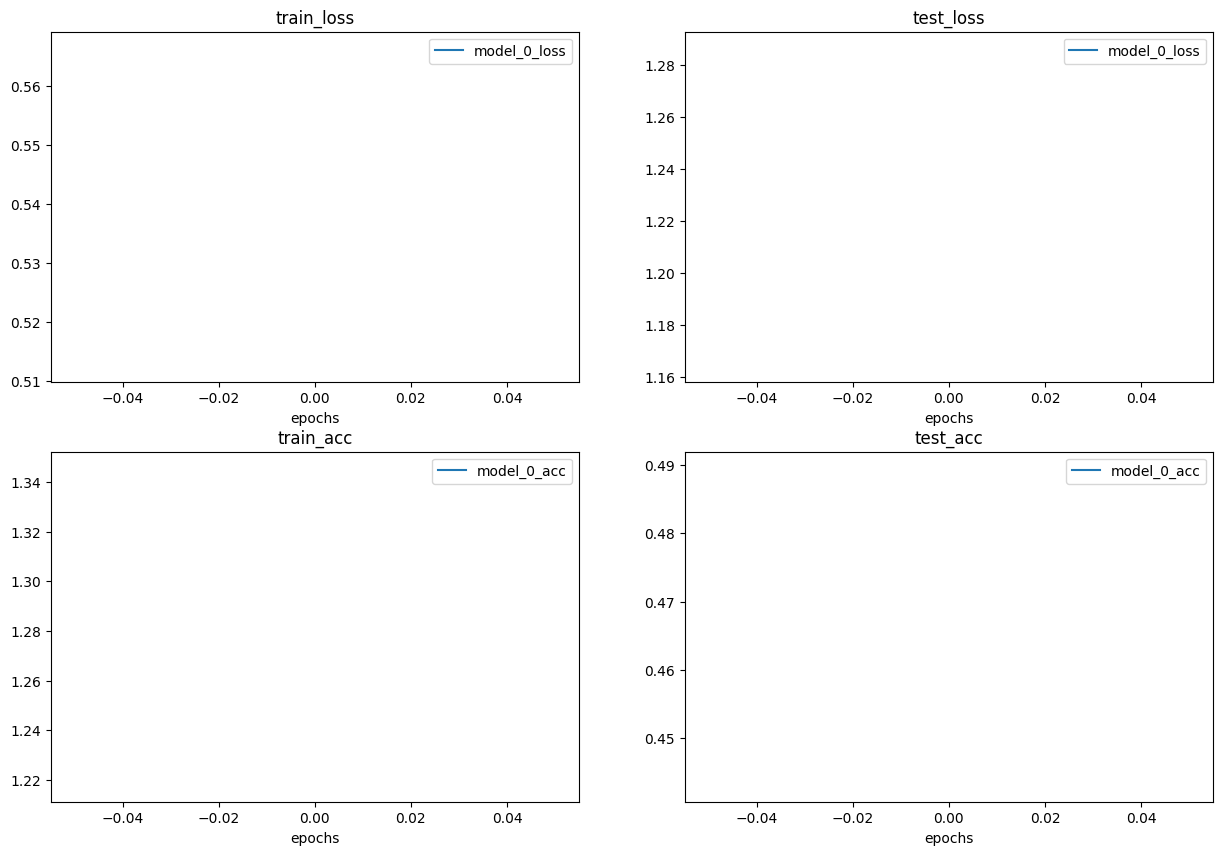

In [16]:
# ------ Complete subplot functions in the following lines -------
plt.figure(figsize=(15, 10))

# Plot train loss with label, title, legend
plt.subplot(2, 2, 1)
plt.plot(train_acc_list,label='model_0_loss')  
plt.title('train_loss')
plt.xlabel('epochs')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(train_loss_list,label='model_0_loss')  
plt.title('test_loss')
plt.xlabel('epochs')
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(valid_loss_list,label='model_0_acc') 
plt.title('train_acc')
plt.xlabel('epochs')
plt.legend()

valid_accuracy_list=[]
for i in valid_acc_list:
    valid_accuracy_list.append(i.tolist())
    
# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(valid_accuracy_list,label='model_0_acc')   

plt.title('test_acc')
plt.xlabel('epochs')
plt.legend()


In [17]:
valid_accuracy_list=[]
for i in valid_acc_list:
    valid_accuracy_list.append(i.tolist())

In [18]:
valid_accuracy_list

[0.4663194417953491]

In [19]:
# 建立模型并读取训练好的权重

#model = get_resnext() # 定义使用的模型
#model = get_resnet()
model = get_resnet18()
#model_path = r'model_save/resnet.pth' #定义保存模型训练权重的名称
# model_path = r'model_save/resnext.pth'
model_path = r'model_save/resnet18.pth'


In [50]:
test_path = r'dataset/test'


test_dataset = torchvision.datasets.ImageFolder (root=test_path, transform=get_transform())

test_loader = DataLoader (dataset=test_dataset, batch_size=32, shuffle=True)

In [21]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear (num_ftrs, 5)
model.load_state_dict (torch.load (model_path))
model = model.to (device)

criterion = nn.CrossEntropyLoss ()

model.eval ()
test_loss = []
test_accs = []


In [22]:


print (f"Test  acc = {test_acc:.5f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.20s/it]

Test  acc = 0.42448


In [23]:
# 对单张图像进行预测
def model_test(model, img_path):
    device = 'cuda'
    data_transform = transforms.Compose ([
        transforms.Resize ((224, 224)),
        transforms.ToTensor (),
    ])

    img = Image.open (img_path)
    img = data_transform (img)
    # 增加一维batch
    img = torch.unsqueeze (img, dim=0)

    model.eval ()
    with torch.no_grad ():
        output = model (img.to (device))
        number = torch.argmax (output.to ('cpu')[0]).numpy ().item ()
    #         print(answer)
    return number



In [24]:
if __name__ == '__main__':
    # 建立模型并读取训练好的权重
    model = get_resnet18 ()
    device = get_device ()
    model.to (device)

    model_path = r'model_save/resnet18.pth'
    model.load_state_dict (torch.load (model_path))

    # 标签到名称的字典
    label_dict = {0:'Albedo', 1:'CC', 2:'CuChulainn', 3:'Gilgamesh', 4:'Sesshomaru'}
    img_pre_labels=[]
    count = 0
    for i in os.listdir(r'prediction'):
        img_path = r'prediction'+'/'+i
        img_pre_label = label_dict [model_test (model, img_path)]
        img_pre_labels.append(img_pre_label)

        print ('picture {} name is： {}'.format(i,img_pre_labels[count]))
        count+=1

picture 0.jpg name is： Sesshomaru
picture 121.jpg name is： Sesshomaru
picture 1231.jpg name is： Gilgamesh
picture 14.jpg name is： CuChulainn
picture 151.jpg name is： Sesshomaru
picture 1caf6844-318e-40e9-ba7b-165e940b74ed.jpg name is： Gilgamesh
picture 212.jpg name is： CuChulainn
picture 26bbdafa-fbfa-47fd-8085-ee39cb39a339.jpg name is： CuChulainn
picture 4815d75a-045c-4798-8924-47c096171664.jpg name is： Gilgamesh
picture 48454aef65a50e3326574f8193a5728b.jpg name is： Gilgamesh
picture 623bb4fc-48fb-48f9-9133-caacc0b99f60.jpg name is： Gilgamesh
picture 712.png name is： CC
picture 713.png name is： CC
picture 81+8S5bSrOL._AC_SL1500_.jpg name is： Gilgamesh
picture 8f190586-cc07-4705-8d2b-e70850332a08.jpg name is： Sesshomaru
picture 94509461-b30b-4b39-99f0-18f5ef79ef2f.jpg name is： Gilgamesh
picture 9999ee9d-2f57-4f43-8f54-37c9d1ccba99.jpg name is： Gilgamesh
picture 9dfa464c-520a-47bc-ba18-7b83485c3b27.jpg name is： CuChulainn
picture a9902035-4156-4f4f-bbf0-1996a26fdca4.jpg name is： Gilgame

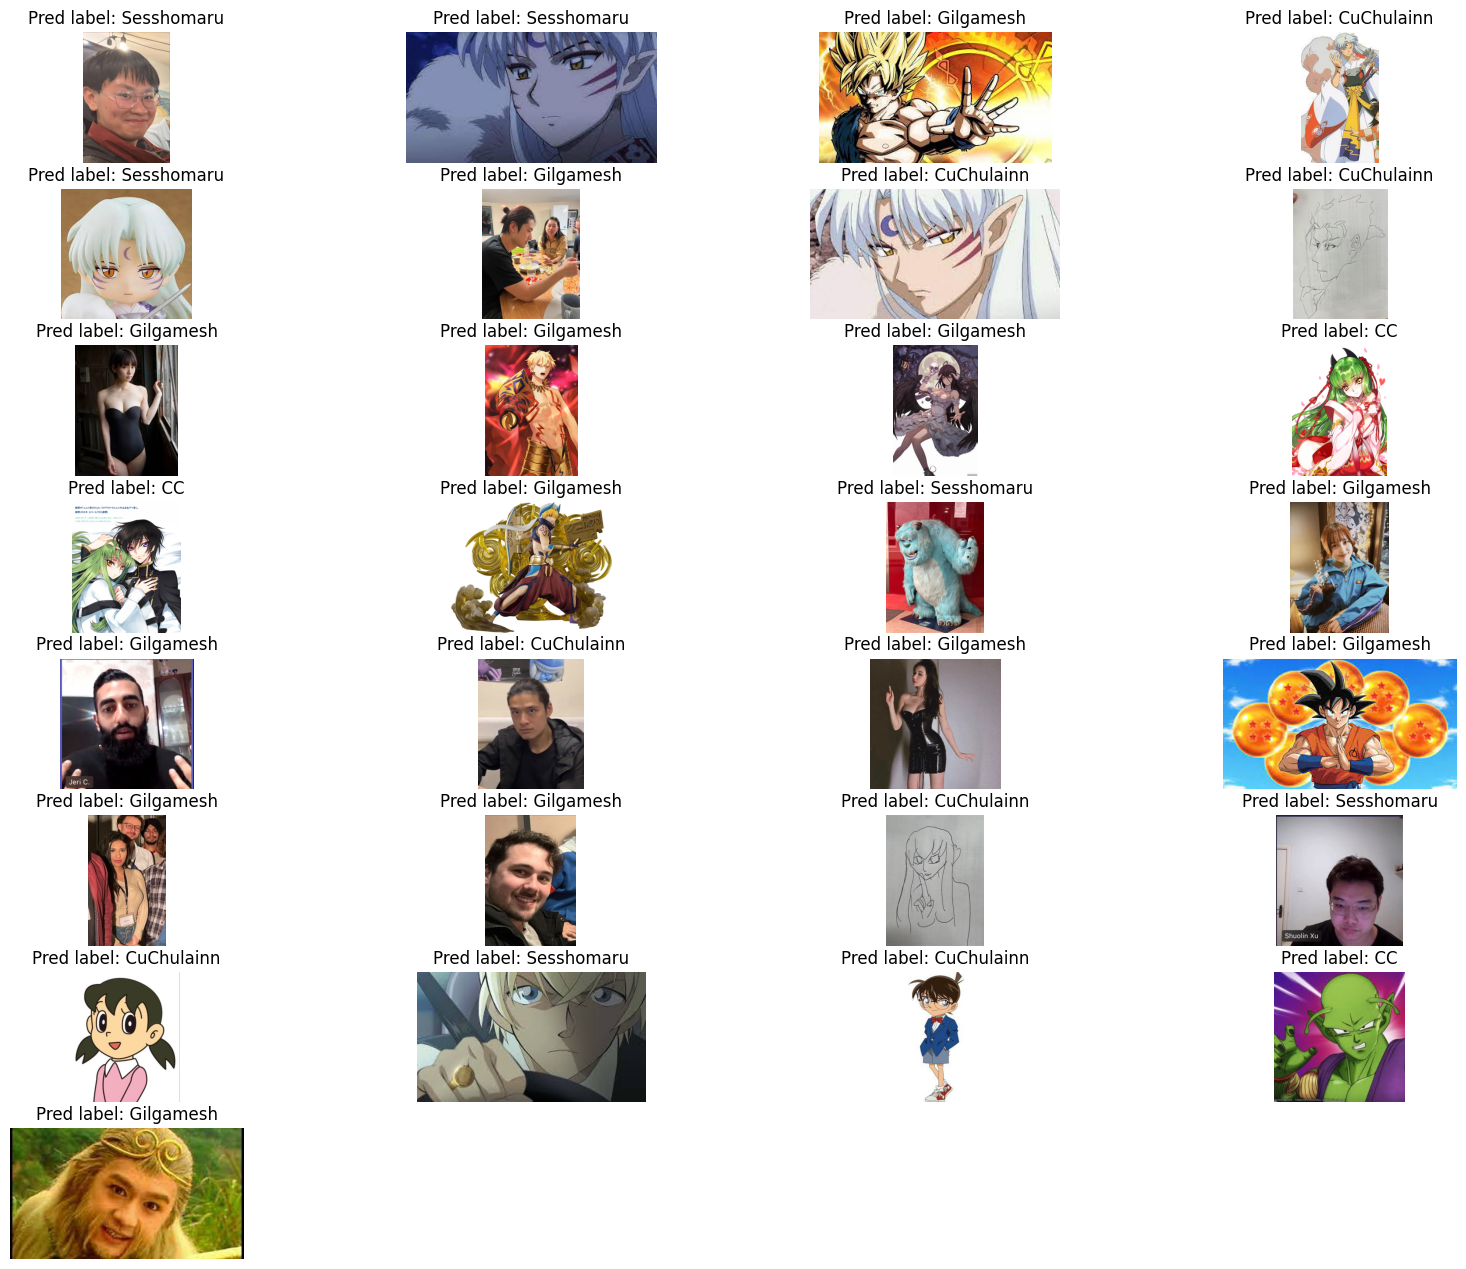

In [25]:
plt.figure(figsize=[20,20])    
count1=1
for i in os.listdir(r'prediction'):
        custom_image = r'prediction'+'/'+ i
        img = torchvision.io.read_image(custom_image)
        plt.subplot(10,4,count1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Pred label: {img_pre_labels[count1-1]}")
        plt.axis(False)
        count1+=1